## NLP e ML

### Processamento de Linguagem Natural e Aprendizado de Máquina

Agora que nossos dados foram lidos e preparados, vamos mergulhar na parte de aprendizado de máquina e processamento de linguagem natural.

Diferentes problemas em Aprendizagem de Máquina possuem diferentes dados de entrada para que seja possível a realização de previsões. Em imagens podemos usar os pixels brutos como entrada, para detecção de fraude em sistemas podemos usar dados referentes ao acesso de clientes e outros recursos disponíveis.

No Processamento de Linguagem Natural não é diferente, precisamos de dados de entrada para realizar as previsões e, esses dados, são as representações textuais do que se pretende avaliar.

No caso deste guia, iremos utilizar as frases (tweets) que foram coletados nos passos anteriores para realizar as predições.

A abordagem mais simples que podemos utilizar é o modelo de mala de palavras ou, como é mais conhecido: bag-of-words. Uma mala de palavras é uma matriz contento uma variação entre 0 e 1 para representar a siginificância de uma palavra em uma determinada setença, em sua abordagem mais simplificada.

Neste guia, usaremos duas abordagens para construção de malas de palavras: Count vectorizer e TF-IDF vectorizer. É necessário

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import gensim

In [ ]:
path  = '/content/drive/MyDrive/atlantico-academy/cognitive-computing'
clean_questions = pd.read_csv(f'{path}/trailhead/nlp/data/clean_questions.csv')

### Count Vectorizer

In [ ]:
# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 
# Separando o texto da variável alvo 
list_corpus = clean_questions["text"].tolist() 
list_labels = clean_questions["class_label"].tolist() 
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(
    list_corpus, 
    list_labels,
    test_size=0.2,
    random_state=42
)                                                           
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

## Visualizando o Vocabulário
Agora que já criamos o vocabulário para treinar o modelo, vamos tentar identificar algum tipo de estrutura semelhante ou agrupamento baseado na variável alvo. No mundo real perfeito, nosso vocabulário seria tão distinto considerando a variável alvo, que estariam distribuidos perfeitamente em grupos separados. A projeção será feita em duas dimensões (LSA).

In [ ]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)        
        lsa.fit(test_data)        
        lsa_scores = lsa.transform(test_data)        
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}        
        color_column = [color_mapper[label] for label in test_labels]        
        colors = ['orange','blue','blue']        

        plt.figure(figsize=(10, 10))           
        plt.scatter(
            lsa_scores[:,0],
            lsa_scores[:,1],
            s=8,
            alpha=.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors)
        )
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')            
        green_patch = mpatches.Patch(color='blue', label='Disaster')           
        plt.legend(handles=[red_patch, green_patch], prop={'size': 20})            
        plt.show()

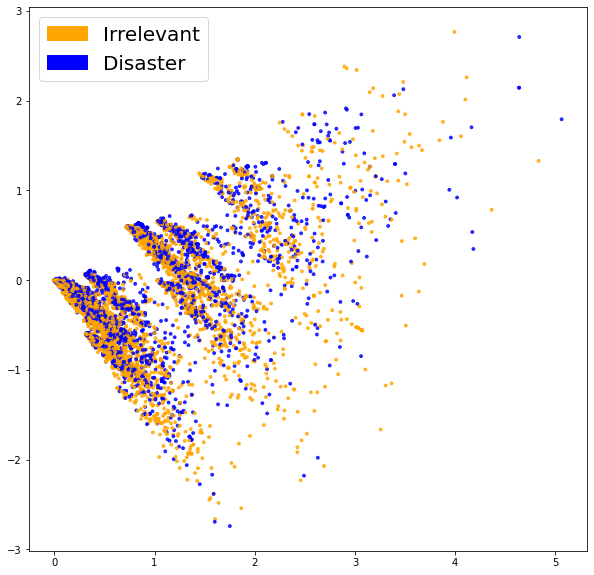

In [ ]:
plot_LSA(X_train_counts, y_train) 

Nosso vocabulário não parece muito bem separado em grupos distintos de palavras que explicam a variável alvo. No entanto, vamos ver se é possível construir um modelo útil para lidar com ele no tutorial de NLP e ML.

## Treinando o Classificador
Vamos iniciar com uma regressão logística, visto que, é simples, e muitas vezes resolve o problema. Além disso, é fácil de interpretar.

In [ ]:
# Aplicando configurações no modelo 
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf.fit(X_train_counts, y_train) 
#Realizando as predições para o conjunto de teste 
y_predicted_counts = clf.predict(X_test_counts)

## Avaliando o Classificador
Agora vamos obervar e avaliar algumas métricas para identificar se nosso classificador apresentou um bom desempenho. Para isso, usaremos métricas comumente utilizadas para avaliação de preditores (precisão, cobertura e medida-f).

In [ ]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste. 
def get_metrics(y_test, y_predicted):      
   # true positives / (true positives+false positives)    
   precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')                 
   # true positives / (true positives + false negatives)    
   recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')        
   # harmonic mean of precision and recall    
   f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')        
   # true positives + true negatives/ total    
   accuracy = accuracy_score(y_test, y_predicted)    
   return accuracy, precision, recall, f1 
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.772, precision = 0.773, recall = 0.772, f1 = 0.772


Um classificador muito bom apresentaria métricas próximas de 1. Logo, para que se aproxime de 1 ou seja exatamente 1, a quantidade de falsos-positivos e falsos-negativos deve ser 0. Avaliando as métricas que extraímos, podemos observar que estamos longe disso.

Para analisar especificamente os erros, usaremos outra abordagem bastante conhecido no meio: a matriz de confusão.

In [ ]:
#Método para plotar a matriz de confusão. 
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.winter): 
    if normalize:        
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title, fontsize=30)    
    plt.colorbar()    
    tick_marks = np.arange(len(classes))    
    plt.xticks(tick_marks, classes, fontsize=20)    
    plt.yticks(tick_marks, classes, fontsize=20)        
    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.     
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] < thresh else "black", fontsize=40)
        plt.tight_layout()   
        plt.ylabel('True label', fontsize=30)    
        plt.xlabel('Predicted label', fontsize=30)     
    return plt

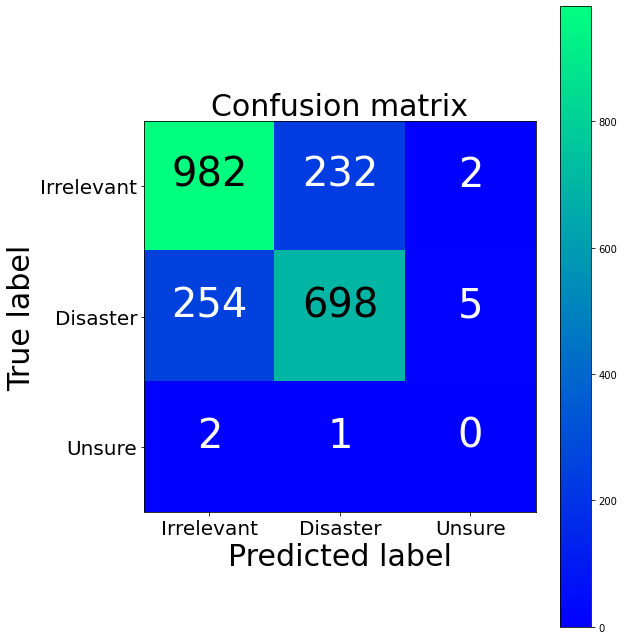

Count Vectorizer confusion matrix
[[982 232   2]
 [254 698   5]
 [  2   1   0]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("Count Vectorizer confusion matrix") 
print(cm)

Como podemos obervar, nosso classificador, para alguns casos, classifica como incerteza algumas das classes que está tentando predizer. Para nós, isso é pouco relevante.

O que mais chama a atenção é ele apontar mais falsos-negativos (textos que remetiam a desastres classificados como não desastrosos) do que falsos-positivos (textos que remetiam a eventos não desastrosos classificados como desastrosos).

Dependendo do caso de uso, isso pode ser aceitável. No entanto, pensando no caso de aplicação para avisar os bombeiros, errar qualquer uma das predições pode gerar uma perda grande para a aplicação real da solução.

Vamos realizar uma inspeção adicional para entender quais features (palavras) estão sendo usadas pelo classificador para tomada de decisão.

In [ ]:
# Método para identificação das features mais importantes na tomada de decisão. 
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    return classes 
importance = get_most_important_features(count_vectorizer, clf, 10)

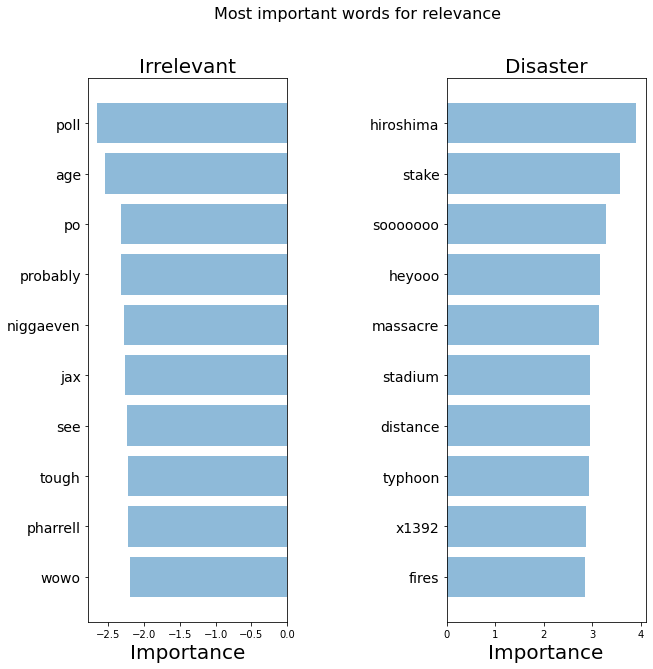

In [ ]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]        
    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Podemos observar que nosso classificador capta alguns padrões realmente relevantes e relacionados com desastres e não desastres (ex. hiroshima e descarrilhamento). No entanto, parece estar aprendendo termos irrelevantes para discriminar os fatos (ex. x1392 e heyooo). Esses termos são tratados como ruídos e, quando se aprende ruídos, identificamos o que chamamos de overfitting (super ajuste do modelo).

## TF-IDF Bag of Words
Nesta seção vamos trabalhar com uma abordagem para construção da mala de palavras (bag-of-words) de uma forma mais refinada. Nós iremos usar agora a abordagem TF-IDF (Term Frequency, Inverse Document Frequency), essa abordagem não realiza apenas a contabilização dos termos, unicamente, pela quantidade de vezes em que ele aparece, mas também leva em consideração em quantos textos ele aparece individualmente.

<Figure size 720x720 with 0 Axes>

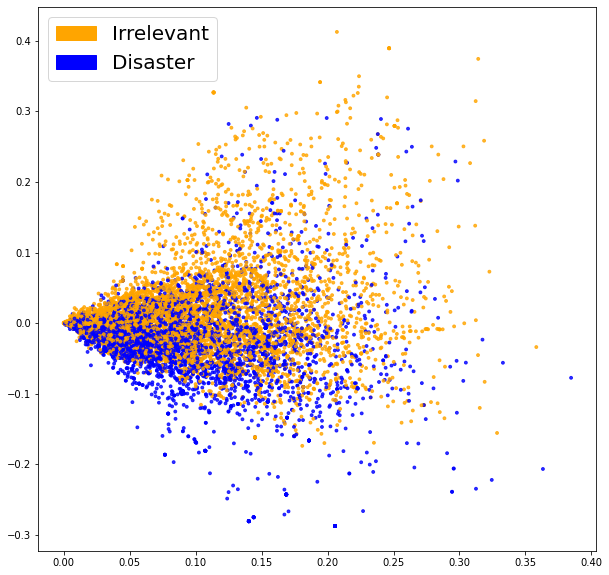

In [ ]:
# Construindo bag-of-words com count-vectorizer 
tfidf_vectorizer = TfidfVectorizer() 
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_tfidf = tfidf_vectorizer.transform(X_test) 
# Plotando a distribuição do vocabulário 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train) 
plt.show()

Obervando o gráfico acima, podemos perceber que a nova abordagem agrupou os dados melhor que a abordagem anterior. Vamos ver se isso impacta na capacidade de predição do classificador?

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',                          multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf_tfidf.fit(X_train_tfidf, y_train) 
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

accuracy = 0.784, precision = 0.783, recall = 0.784, f1 = 0.783


Comparando os novos resultados obtidos, por meio da abordagem para contagem de termos TF-IDF, podemos obervar que obtivemos uma pequena melhora na capacidade de predição do modelo considerando as métricas: precisão, cobertura e medida-f.

Vamos analisar a matriz de confusão e entender como os erros estão acontecendo.

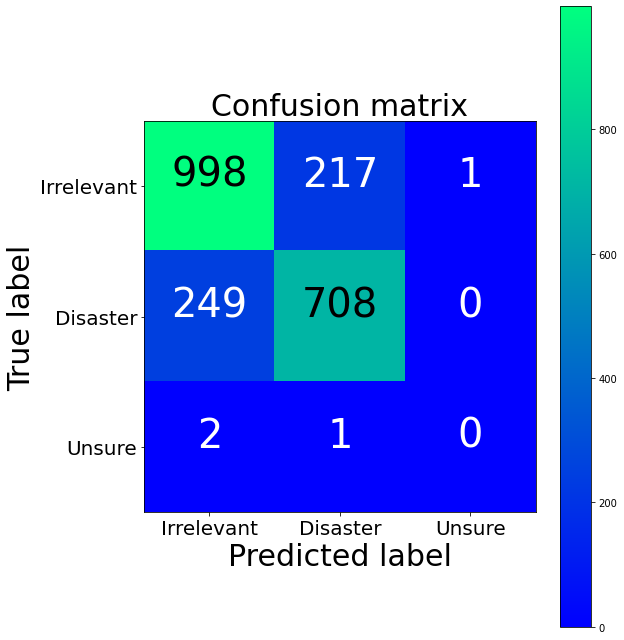

TFIDF confusion matrix
[[998 217   1]
 [249 708   0]
 [  2   1   0]]
BoW confusion matrix
[[982 232   2]
 [254 698   5]
 [  2   1   0]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("TFIDF confusion matrix") 
print(cm2) 
print("BoW confusion matrix") 
print(cm)

 Podemos observar que tivemos uma redução na quantidade de falsos-positivos e falsos-negativos.

Vamos obervar quais palavras foram consideradas mais importantes para tomada de decisão do novo classificador.

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

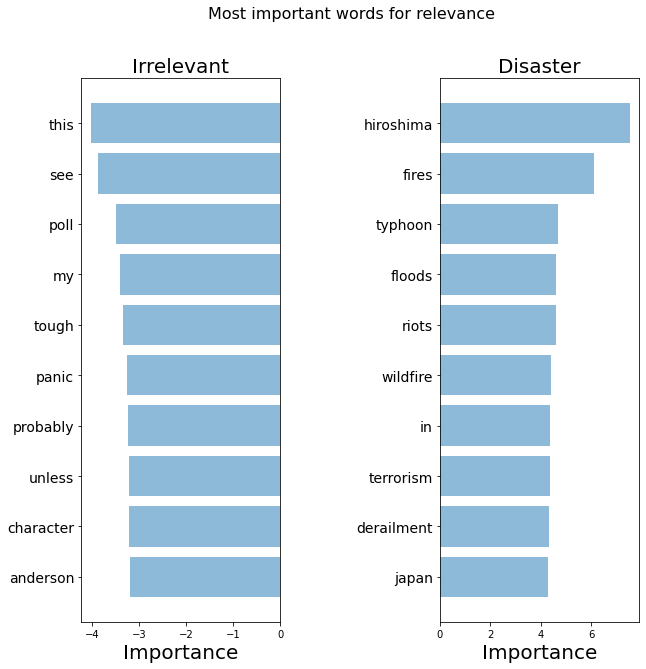

In [ ]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Vemos que a ordem de relevância das palavras mudou bastante e que muitas palavras pouco relevantes para identificar os fatos foram descartadas. Sendo assim, podemos ter mais confiança nos resultados que obtivemos aqui e, também, que realmente obtivemos uma melhora em relação ao processo anterior, embora não tenha sido muito grande.

## Capturando o Significado Semântico das Palavras
Os dois primeiros modelos captam palavras de alta relevância. No entanto, é improvável que qualquer problema de NLP e ML apresente um conjunto de treinamento com todas as palavras realmente relevantes. Para resolver esse problema, é possível capturar o significado semântico das palavras. Ou seja, precisamos entender o grau de relação semântica que as palavras "bom"/"postivo" e "cereja"/"continente" apresentam entre si, por exemplo.

## Usando o Word2vec
O Word2vec é um modelo que foi pré-treinado com um conjunto de dados muito grande e fornece integrações que mapeiam palavras semanticamente relacionadas. Iremos trabalhar com a média das pontuações de similaridade de todas as palavras em nossas sentenças. A ideia da abordagem é que, quanto mais próximas semanticamente elas forem, mais próximo o peso delas será.

In [ ]:
!wget GoogleNews-vectors-negative300.bin.gz

--2022-04-28 17:10:03--  http://googlenews-vectors-negative300.bin.gz/
Resolving googlenews-vectors-negative300.bin.gz (googlenews-vectors-negative300.bin.gz)... failed: Name or service not known.
wget: unable to resolve host address ‘googlenews-vectors-negative300.bin.gz’


In [ ]:
#Treinando a matriz de relação com notícias do Google 
#O conjunto de dados para treinar a matriz pode ser acessado em: #https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
word2vec_path = "GoogleNews-vectors-negative300.bin.gz" 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

FileNotFoundError: ignored

In [ ]:
#Método para calcular a distância semântica entre as palavras 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
       return np.zeros(k)    
    if generate_missing:        
       vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
       vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    return averaged 
#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels) 
plt.show()

Como podemos obervar, nosso vocabulário parece ter sido melhor separado agora. Para os termos com pesos positivos a tendência é ele ser discriminatório para a classe positiva, para os termos com pesos negativos a tendência se inverte. Vamos ver como nosso modelo se comporta agora.



In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

Analisando as métricas, continuamos melhorando o poder de tomada de decisão do modelo.

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) print("TFIDF confusion matrix") print(cm2) print("BoW confusion matrix") 
print(cm)

Observando a matriz, nosso modelo é estritamente melhor em todos os aspectos que os dois primeiros.

Por fim, espero que esse guia, mesmo que em uma linguagem mais alto nível, explicando os principais passos tomados, tenha servido de material de apoio para seus estudos sobre NLP e ML.